In [1]:
import numpy as np
from cmath import sqrt
from scipy.special import kv
import matplotlib.pyplot as plt
from matplotlib import ticker
import scipy.special
from scipy import stats
from mpmath import *
import math
import datetime
import plotly.graph_objects as go

# Параметры продуцирующего интервала
delta_z = 0.2                      # Шаг по глубине

# Начальные параметры пласта и флюида

C = 0.1                            # Коэффициент (см. рис. 1 в описании)
r_w = 0.1                          # Радиус скважины
c_f = 7E-10 #природный газ - 7E-8, газ - 2E-8, вода - 5E-10 # 7E-10                        # Сжимаемость флюида
c = 3E-11                          # Сжимаемость флюидонасыщенного пласта
V_w = 50                           # Объём скважины
fi = 0.32                          # Пористость пласта
h = 1                              # Продуктивный интервал
k = 1.00e-12                       # Проницаемость пласта
mu = 0.002 #природный газ - 0.000015, газ - 0.0001, вода - 0.0009 # 0.002                         # Вязкость флюида
lamb = k / (fi * mu * c)
N = 16
p_0_array = [1.0E6, 2 * 1.0E6, 1/2 * 1.0E6, 3/4 * 1.0E6, 6/5 * 1.0E6, ]       # Массив p_0 для разных моментов времени
# p_0_array = [1.0E6, 1.0E6, 1.0E6, 1.0E6, 1.0E6, ]       # Массив p_0 для разных моментов времени
t_array = np.array([0, 8640000, 2 * 8640000, 3 * 8640000, 4 * 8640000, ])     # Массив времен в секундах, соответствующих разным p_0
p_e = 15.0E6                       # Давление в пласте

# Параметры для вычисления критического BHP

mu_poisson = 0.25                  # Коэффициент Пуассона
alpha = 0.7                        # Коэффициент Био
phi = 30. / 180 * np.pi             # Угол внутренного трения
sigma_h = 48.0E6 * 0.7                     # Полное минимальное горизонтальное напряжение на отдалении от скважины
sigma_H = 54.0E6 * 0.7                     # Полное максимальное горизонтальное напряжение на отдалении от скважины
sigma_v = 42.0E6 * 0.7
xi = alpha * (1 - 2 * mu_poisson) / (1 - mu_poisson)
f = 0.32                            # Пористость ненарушенной среды
C_cohesion = 12E6                  # Когезия
K = np.tan(np.pi / 4 + phi / 2)

# Параметры для вычисления расхода песка q_s

phi_i_array = [0.32, 0.31, 0.33, 0.315, 0.325]       # Пористость ненарушенной зоны
phi_p_array = [0.4, 0.41, 0.42, 0.39, 0.38]             # Пористость пластической зоны
k_i_array = [1.0E-12, 1.05E-12, 0.9E-12, 0.95E-12, 1.1E-12] # Пронициаемость ненарушенной зоны
k_p_array = [2.5E-12, 2.6E-12, 2.4E-12, 2.45E-12, 2.55E-12] # Пронициаемость пластической зоны

skin_factor = -5.635
r_e_array = r_w * np.exp(skin_factor / (np.divide(k_i_array, k_p_array) - 1))          # Массив радиусов дренирования для различных глубин

# Параметры для вычисления начального расхода песка

T = 2 * np.sin(phi) / (1 - np.sin(phi))
gamma_p = 0.6      # Не варьировать
UCS_p = 1.0E6      #Предел прочности на одноосное сжатие
p_inf = 7.0E6      # Не варьировать
p_c = 15.0E6       # Не варьировать
t_p = 100          # Не варьировать

S_array = []       # Массив объёмов вынесенного песка на 1 метр скважины

print('Начальные параметры пласта и флюида:')
print()
print('C =                                                ', C)
print('r_w (Радиус скважины) =                            ', r_w, ' m')
print('c_f (Сжимаемость флюида) =                         ', c_f, 'Pa^-1')
print('c (Сжимаемость флюидонасыщенного пласта) =         ', c, 'Pa^-1')
print('V_w (Объём скважины) =                             ', V_w, 'm^3')
print('ϕ (Пористость пласта) =                            ', fi)
print('h (Продуктивный интервал) =                        ', h, 'm')
print('k (Проницаемость пласта) =                         ', k, 'm^2')
print('μ (Вязкость флюида) =                              ', mu, 'Pa * s')
print('N =                                                ', N)

print()

print('Параметры для вычисления критического BHP:')
print()
print('mu_poisson (Коэффициент Пуассона) =                ', mu_poisson, '')
print('alpha (Коэффициент Био) =                          ', alpha, '')
print('phi (Угол внутренного трения) =                    ', phi, 'радиан')
print('sigma_h (Минимальное горизонтальное напряжение) =  ', sigma_h, 'Pa')
print('sigma_H (Максимальное горизонтальное напряжение) = ', sigma_H, 'Pa')
print('f (Пористость ненарушенной среды) =                ', f, '')
print('C_cohesion (Когезия) =                             ', C_cohesion, 'Pa')
print('xi =                                               ', xi)
print('K =                                                ', K)

print()

print('Параметры для вычисления расхода песка q_s:')
print()
print('r_e (Радиус дренирования) =                        ', r_e_array, 'm')
print('phi_i (Пористость ненарушенной зоны) =             ', phi_i_array, '')
print('phi_p (Пористость пластической зоны) =             ', phi_p_array, '')
print('k_i (Проницаемость ненарушенной зоны) =           ', k_i_array, 'm^2')
print('k_p (Проницаемость пластической зоны) =           ', k_p_array, 'm^2')

Начальные параметры пласта и флюида:

C =                                                 0.1
r_w (Радиус скважины) =                             0.1  m
c_f (Сжимаемость флюида) =                          7e-10 Pa^-1
c (Сжимаемость флюидонасыщенного пласта) =          3e-11 Pa^-1
V_w (Объём скважины) =                              50 m^3
ϕ (Пористость пласта) =                             0.32
h (Продуктивный интервал) =                         1 m
k (Проницаемость пласта) =                          1e-12 m^2
μ (Вязкость флюида) =                               0.002 Pa * s
N =                                                 16

Параметры для вычисления критического BHP:

mu_poisson (Коэффициент Пуассона) =                 0.25 
alpha (Коэффициент Био) =                           0.7 
phi (Угол внутренного трения) =                     0.5235987755982988 радиан
sigma_h (Минимальное горизонтальное напряжение) =   33600000.0 Pa
sigma_H (Максимальное горизонтальное напряжение) =  37800000.

In [2]:
# Функция delta_p_rel в пространстве Лапласа - формула (5)
def F_delta_p_rel(r, s):
    result = 1 / s * C * kv(0, r * s**0.5 / r_w) / \
             (s**0.5 * kv(1, s**0.5) + (C + c_f * V_w * s / (2 * np.pi * c * fi * r_w**2 * h)) * kv(0, s**0.5)) 
    return complex(result.real, result.imag)

# Функция Q_rel в пространстве Лапласа - формула (10)
def F_Q_rel(s):
    result = 2 * np.pi * k * h / mu * C * s**(-0.5) * kv(1, s**0.5) / \
             (s**0.5 * kv(1, s**0.5) + (C + c_f * V_w * s / (2 * np.pi * c * fi * r_w**2 * h)) * kv(0, s**0.5))
    return complex(result.real, result.imag)

# Коэффициенты для расчёта методом Gaver-Stehfest - формула (7)
def V(i):
    return np.sum([(-1)**(N / 2 + i) * k**(N / 2) * factorial(2 * k) / \
                   (factorial(N / 2 - k) * factorial(k) * factorial(k - 1) * factorial(i - k) * factorial(2 * k - i)) \
                   for k in np.arange(int((i + 1) / 2), min(i, N / 2) + 1, 1)])

# Функция delta_p_rel во временном пространстве - формула (9)
def f_delta_p_rel(r, t):
#     Предельный случай при t -> 0. Заменяем значение функции в точке на предел справа по t в данной точке
    if ((r >= r_w) & (t == 0)):
        return 0
#     Переходим от реального времени к нормированному, для которого задано решение
    t_d = lamb * t / r_w**2
#     Используем метод расчёта Gaver-Stehfest
    return float(np.sum([np.log(2) / t_d * V(i) * F_delta_p_rel(r, np.log(2) * i / t_d) for i in np.arange(1, N + 1, 1)]).real)

# Функция Q во временном пространстве для фиксированных p_e и p_0 - формула (11)
def Q(t, p_e, p_0):
#     Предельный случай при t -> 0. Заменяем значение функции в точке на предел справа по t в данной точке
    if t == 0:
        return 0
#     if p_e < BHP_critical(p_e, p_e):
#         return 0
    t_d = lamb * t / r_w**2
    return float((p_e - p_0) * np.sum([np.log(2) / t_d * V(i) * F_Q_rel(np.log(2) * i / t_d) for i in np.arange(1, N + 1, 1)]).real)


# Функция расхода песка на 1 метр скважины q_s для различных параметров среды и фиксированных p_e и p_0
# t - массив времен
def q_s(t, Q, p_e, p_0_array, k_i, k_p, phi_i, phi_p, r_e):
    global S_array
    if p_e < BHP_critical_Mogi(p_e, p_e) or Q[1] == 0:
        S_array = [0 for n in range(len(t))]
        return [0 for n in range(len(t)- 1)]
    
#   S - объём вынесенного песка на 1 метр скважины
    S = np.zeros(len(t))
    delta_t = t[1] - t[0]
#   Коэффициенты в явной схеме. Заданы просто для удобства написания огромной формулы, физического смысла не несут.  
    B = mu / (2 * np.pi * k_p * phi_p * (1 - phi_p))
    C_1 = mu / (2 * np.pi * k_p * phi_p)
    C_2 = - mu / (2 * np.pi * k_i * phi_i)
    D = r_e / r_w
    E = np.log(D)
    
#   В начальный момент времени вынесенного песка нет. Ставим S почти ноль, потому что при S = 0 схема расходится
    S[0] = 1E-15
#     S[1] = q_s_initial(p_e, p_0_array[np.where(t_array <= t[0])[0][-1]], k_i, k_p, phi_i, phi_p, r_e) * delta_t + S[0]
    S[1] = q_s_initial(p_e, p_0_array[[i for i, t_k in enumerate(t_array) if t_k <= t[0]][-1]], k_i, k_p, phi_i, phi_p, r_e) * delta_t + S[0]
    for n in range(2, len(t)):
#       Еще один коэффициент явной схемы  
#         A = p_e - p(r_w, t[n - 1], p_e, p_0_array[np.where(t_array <= t[n - 1])[0][-1]])
        A = p_e - p(r_w, t[n - 1], p_e, p_0_array[[i for i, t_k in enumerate(t_array) if t_k <= t[n - 1]][-1]])
        
#       Явная схема - формула (14)
        S[n] = S[n - 1] + delta_t * ( \
                                      Q[n - 1] / h * (C_1 + C_2) / B - \
                                     (C_2 * E * Q[n - 1] / h + A) / (B * 0.5 * np.log(1 + S[n - 1] / (np.pi * r_w**2 * (phi_p - phi_i)))) \
                                    )
#         print(n, " ", S[n], " ", A)
    
    S_array = S.copy()
    q_s = [(S[n + 1] - S[n]) / delta_t for n in range(len(t)- 1)]
    q_s = [0 if i < 0 else i for i in q_s]
#     for i in q_s:
#         if i < 0: i = 0
#   Возвращаем массив q_s для каждого момента времени  
    return q_s

# Функция расхода песка в начальный момент времени
def q_s_initial(p_e, p_0, k_i, k_p, phi_i, phi_p, r_e):
    a = mu / (2 * np.pi * k_p * phi_p * (1 - phi_p)) * (T + gamma_p - 0.5 * gamma_p / \
                                                    (np.log(r_e / r_w))) / (2 * np.pi * r_w**2 * (phi_p - phi_i))
    b = (UCS_p - k_i * phi_i * (p_e - p_e) / (k_p * phi_p * np.log(r_e / r_w))) * (1 + 0.5 * T) / \
                                                    (2 * np.pi * r_w**2 * (phi_p - phi_i))
    c = -(p_c - p_inf) / t_p * (1 - 0.5 * gamma_p + 0.25 * gamma_p / np.log(r_e / r_w))
    
    q_s_1 = (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)
    q_s_2 = (-b - np.sqrt(b**2 - 4 * a * c)) / (2 * a)
    
    return max(q_s_1, q_s_2)
    
# Функция P' во временном пространстве для фиксированных p_e и p_0
def p_der(t, p_e, p_0):
#     Предельный случай при t -> 0. Заменяем значение функции в точке на значение, полученное по формуле (A1), так как экспериментально доказана
    if t == 0:
        return C * 2 * np.pi * k * h * r_w**2 / (c_f * V_w * mu * lamb) * (p_0 - p_e)
    t_d = lamb * t / r_w**2
    return float(np.sum([ -np.log(2)**2 / t_d**2 * (p_e - p_0) * i * V(i) * F_delta_p_rel(r_w, np.log(2) * i / t_d) for i in np.arange(1, N + 1, 1)]).real)

# Функция p во временном пространстве для фиксированных p_e и p_0 - формула (8)
def p(r, t, p_e, p_0):
    return p_e - (p_e - p_0) * f_delta_p_rel(r, t)

# Функция критического давления BHP по критерию Моги-Кулона
# P_p - начальное поровое давление
# P_p1 - текущее поровое давление
def BHP_critical_Mogi(p_p, p_p1):
    
    m = 2 * np.sqrt(2) / 3 * C_cohesion * np.cos(phi)
    q = 2 * np.sqrt(2) / 3 * np.sin(phi)
    
    A = 3 * sigma_H - sigma_h - xi * p_p1
    B = sigma_v + 2 * mu_poisson * (sigma_H - sigma_h) - xi * p_p1
    
    C = 2 * xi**2 - 6 * xi + 6 - 9 * q**2 * (xi - 2 * alpha)**2 / 4
    D = 2 * xi * (A + B) - 6 * A - 9 * (xi - 2 * alpha) * (2 * m * q + q**2 * A) / 2
    E = 2 * (A**2 + B**2 - A * B) - 9 * (2 * m + q * A)**2 / 4

    return (-D - np.sqrt(D**2 - 4 * C * E)) / (2 * C)    
    
# Правая часть равенства формулы (2)
def p_2(t, p_e, p_0):
    return p_0 + mu / (2 * np.pi * k * h * C) * (Q(t, p_e, p_0) - c_f * V_w * lamb / r_w**2 * p_der(t, p_e, p_0))

In [3]:
t_2_delta = 10000               # Шаг по времени
r_array_delta = 0.01            # Шаг по радиусу
t_2 = np.arange(0, 40000000, t_2_delta)      # Массив времен
r_array = np.arange(r_w, r_w * 10, r_array_delta)     # Массив радиусов
t_0 = 100                                             # Некоторый момент времени

# Расчет расхода песка суммированием по дискретному набору глубин

In [4]:
# Q_array = [Q(t_i, p_e, p_0_array[np.where(t_array <= t_i)[0][-1]]) for t_i in t_2]     # Массив расходов флюида
Q_array = [Q(t_i, p_e, p_0_array[[i for i, t_k in enumerate(t_array) if t_k <= t_i][-1]]) for t_i in t_2]     # Массив расходов флюида
Q_s_array = np.zeros(len(t_2) - 1)                 # Массив расходов песка
Q_s_matrix = []
for i in range(len(k_i_array)):              # Суммируем расходы 
    q_s_array = q_s(t_2, Q_array, p_e, p_0_array, k_i_array[i], k_p_array[i], phi_i_array[i], phi_p_array[i], r_e_array[i])
    Q_s_array = Q_s_array + np.dot(q_s_array, delta_z)
    Q_s_matrix.append(np.dot(q_s_array, delta_z)[2:])

Text(0, 0.5, 'Q_s, м^3 / с')

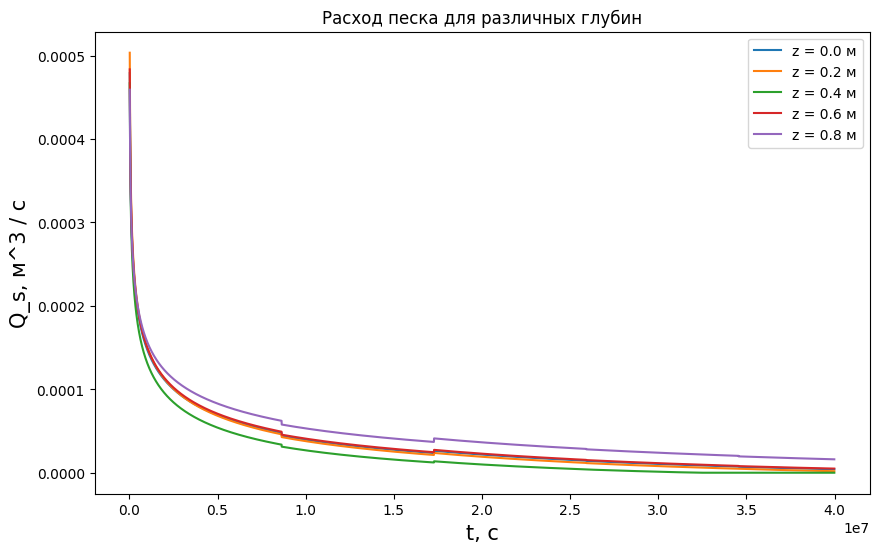

In [5]:
plt.figure(figsize=(10,6))
for i in range(len(Q_s_matrix)):
    plt.plot(t_2[2:-1],Q_s_matrix[i], label='z = ' + str(int(delta_z * i * 10) / 10) + ' м')
plt.legend()
plt.title('Расход песка для различных глубин')
plt.xlabel('t, с', size='15')
plt.ylabel('Q_s, м^3 / с', size='15')

# Расчет расхода песка для одной глубины

In [6]:
z_i = 2                          # Индекс точки массива z_array, в которой хотим посчитать расход песка
# Q_array = [Q(t_i, p_e, p_0_array[np.where(t_array <= t_i)[0][-1]]) for t_i in t_2]
Q_array = [Q(t_i, p_e, p_0_array[[i for i, t_k in enumerate(t_array) if t_k <= t_i][-1]]) for t_i in t_2]
q_s_array = q_s(t_2, Q_array, p_e, p_0_array, k_i_array[z_i], k_p_array[z_i], phi_i_array[z_i], phi_p_array[z_i], r_e_array[z_i])
Q_s_array = np.dot(q_s_array, delta_z)

p_e =  15000000.0  Па
Critical BHP =  7913361.690076712  Па


Text(0, 0.5, 'Q_s, м^3 / с')

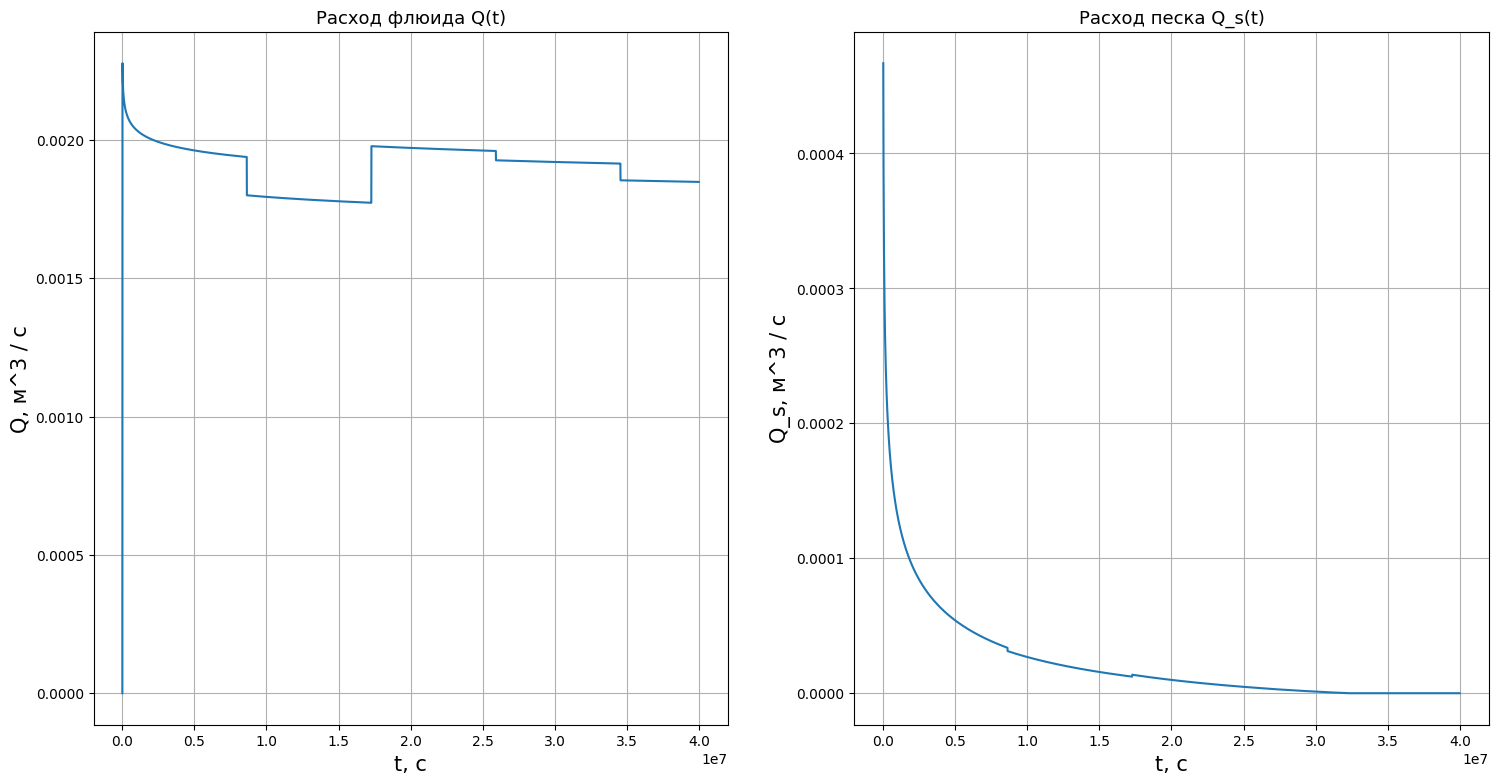

In [7]:
fig = plt.figure()
fig.set_figheight(9)
fig.set_figwidth(18)
ax = fig.add_subplot(121)

print('p_e = ', p_e, ' Па')
print('Critical BHP = ', BHP_critical_Mogi(p_e, p_e), ' Па')

plt.plot(t_2, Q_array)
ax2 = fig.add_subplot(122)
ax.grid()
ax.set_xlabel('t, с', size='15')
ax.set_ylabel('Q, м^3 / с', size='15')
ax.set_title('Расход флюида Q(t)', size='13')
plt.plot(t_2[2:-1], Q_s_array[2:])
ax2.grid()
ax2.set_title('Расход песка Q_s(t)', size='13')
ax2.set_xlabel('t, с', size='15')
ax2.set_ylabel('Q_s, м^3 / с', size='15')

# Расчет накопленной добычи песка

Text(0.5, 1.0, 'Объём песка V(t)')

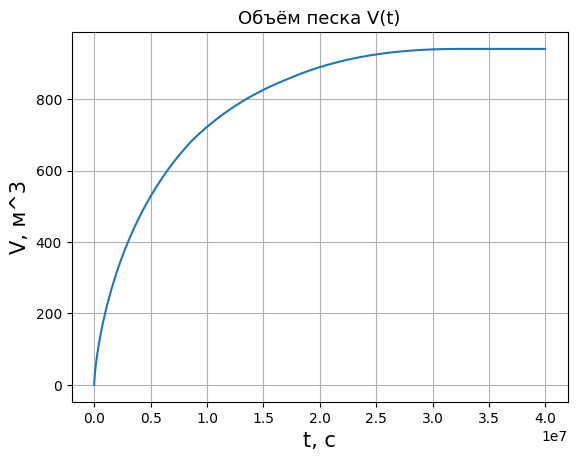

In [8]:
V_array = []
for i in range(len(t_2) - 1):
    if i == 0:
        V_array.append(0)
    else:
        V_array.append(V_array[i - 1] + Q_s_array[i] * t_2_delta)

plt.plot(t_2[:-1], V_array)
plt.grid()
plt.xlabel('t, с', size='15')
plt.ylabel('V, м^3', size='15')
plt.title('Объём песка V(t)', size='13')

# Анализ чувствительности

In [9]:
tau_i = len(t_2) // 10                      # Момент времени, при котором проводится анализ чувствительности
deviation = 0.1                             # Отклонение аргумента
z_i = 1                                     # Индекс точки массива z_array, в которой хотим посчитать чувствительность

# Вычисление значения расхода песка, относительно которого будет проводится измерение чувствительности
# Q_array = [Q(t_i, p_e, p_0_array[np.where(t_array <= t_i)[0][-1]]) for t_i in t_2]
Q_array = [Q(t_i, p_e, p_0_array[[i for i, t_k in enumerate(t_array) if t_k <= t_i][-1]]) for t_i in t_2]
q_s_array = q_s(t_2, Q_array, p_e, p_0_array, k_i_array[z_i], k_p_array[z_i], phi_i_array[z_i], phi_p_array[z_i], r_e_array[z_i])
Q_s_array = np.dot(q_s_array, delta_z)
Q_s_mean = Q_s_array[tau_i]                 

In [10]:
positive_bars = []                          # Список значений расхода песка для каждого параметра при положительном отклонении аргумента
negative_bars = []                          # Список значений расхода песка для каждого параметра при отрицательном отклонении аргумента

In [11]:
# Набор аргументов, для которых проводится анализ чувсвительности
bar_labels = ['c_f', 'c', 'fi', 'k', 'mu', 'mu_poisson', 'alpha', 'phi', 'sigma_h', 'sigma_H', 'C_cohesion', 'phi_p', 'k_p', 'skin_factor']
bar_labels_russian = ['Сжимаемость флюида', 'Сжимаемость флюидонасыщенного пласта', 'Пористость пласта (ненарушенной зоны)', 'Проницаемость пласта (ненарушенной зоны)', 'Вязкость флюида', 'Коэффициент Пуассона', 'Коэффициент Био', 'Угол внутреннего трения', 'Минимальное горизонтальное напряжение', 'Максимальное горизонтальное напряжение', 'Когезия', 'Пористость пластической зоны', 'Проницаемость пластической зоны', 'Скин-фактор',]

# Вычисление чувствительности значений расхода песка при заданном отклонении параметров пласта и флюида
# sign - +1 или -1, означающий отклонение аргумента в положительную или отрицательную сторону
def compute_deviation(sign):
    global positive_bars, negative_bars, bar_labels, c_f, c, fi, k, mu, mu_poisson, xi, K, lamb, r_e_array, T, skin_factor, alpha, phi, sigma_h, sigma_H, f, C_cohesion, phi_i_array, k_i_array, phi_p_array, k_p_array
    for i in bar_labels:
        if i ==  'c_f': c_f = (1 + sign * deviation) * c_f
        elif i == 'c': c = (1 + sign * deviation) * c
        elif i == 'fi': 
            fi = (1 + sign * deviation) * fi
            f = (1 + sign * deviation) * f
            phi_i_array = np.dot(phi_i_array, 1 + sign * deviation)
        elif i ==  'k': 
            k = (1 + sign * deviation) * k
            k_i_array = np.dot(k_i_array, 1 + sign * deviation)
        elif i == 'mu': mu = (1 + sign * deviation) * mu
        elif i == 'mu_poisson': mu_poisson = (1 + sign * deviation) * mu_poisson
        elif i == 'alpha': alpha = (1 + sign * deviation) * alpha
        elif i == 'phi': phi = (1 + sign * deviation) * phi
        elif i == 'sigma_h': sigma_h = (1 + sign * deviation) * sigma_h
        elif i == 'sigma_H': sigma_H = (1 + sign * deviation) * sigma_H
        elif i == 'C_cohesion': C_cohesion = (1 + sign * deviation) * C_cohesion
        elif i == 'phi_p': phi_p_array = np.dot(phi_p_array, 1 + sign * deviation)
        elif i == 'k_p': k_p_array = np.dot(k_p_array, 1 + sign * deviation)
        elif i == 'skin_factor': skin_factor = (1 + sign * deviation) * skin_factor
               
        xi = alpha * (1 - 2 * mu_poisson) / (1 - mu_poisson)
        K = np.tan(np.pi / 4 + phi / 2)
        lamb = k / (fi * mu * c)
        r_e_array = r_w * np.exp(skin_factor / (np.divide(k_i_array, k_p_array) - 1))
        T = 2 * np.sin(phi) / (1 - np.sin(phi))
        
        
        Q_array = [Q(t_i, p_e, p_0_array[np.where(t_array <= t_i)[0][-1]]) for t_i in t_2]
        q_s_array = q_s(t_2, Q_array, p_e, p_0_array, k_i_array[z_i], k_p_array[z_i], phi_i_array[z_i], phi_p_array[z_i], r_e_array[z_i])
        Q_s_array = np.dot(q_s_array, delta_z)
        if (sign == 1):
            positive_bars.append(Q_s_array[tau_i] - Q_s_mean)
        else:
            negative_bars.append(Q_s_array[tau_i] - Q_s_mean)

        if i == 'c_f': c_f = c_f / (1 + sign * deviation)
        elif i == 'c': c = c / (1 + sign * deviation)
        elif i == 'fi': 
            fi = fi / (1 + sign * deviation)
            f = f / (1 + sign * deviation)
            phi_i_array = np.dot(phi_i_array, 1 / (1 + sign * deviation))
        elif i == 'k': 
            k = k / (1 + sign * deviation)
            k_i_array = np.dot(k_i_array, 1 / (1 + sign * deviation))
        elif i == 'mu': mu = mu / (1 + sign * deviation)
        elif i == 'mu_poisson': mu_poisson = mu_poisson / (1 + sign * deviation)
        elif i == 'alpha': alpha = alpha / (1 + sign * deviation)
        elif i == 'phi': phi = phi / (1 + sign * deviation)
        elif i == 'sigma_h': sigma_h = sigma_h / (1 + sign * deviation)
        elif i == 'sigma_H': sigma_H = sigma_H / (1 + sign * deviation)
        elif i == 'C_cohesion': C_cohesion = C_cohesion / (1 + sign * deviation)
        elif i == 'phi_p': phi_p_array = np.dot(phi_p_array, 1 / (1 + sign * deviation))
        elif i == 'k_p': k_p_array = np.dot(k_p_array, 1 / (1 + sign * deviation))
        elif i == 'skin_factor': skin_factor = skin_factor / (1 + sign * deviation)
                
        xi = alpha * (1 - 2 * mu_poisson) / (1 - mu_poisson)
        K = np.tan(np.pi / 4 + phi / 2)
        lamb = k / (fi * mu * c)
        r_e_array = r_w * np.exp(skin_factor / (np.divide(k_i_array, k_p_array) - 1))
        T = 2 * np.sin(phi) / (1 - np.sin(phi))
        

In [12]:
compute_deviation(1)
compute_deviation(-1)

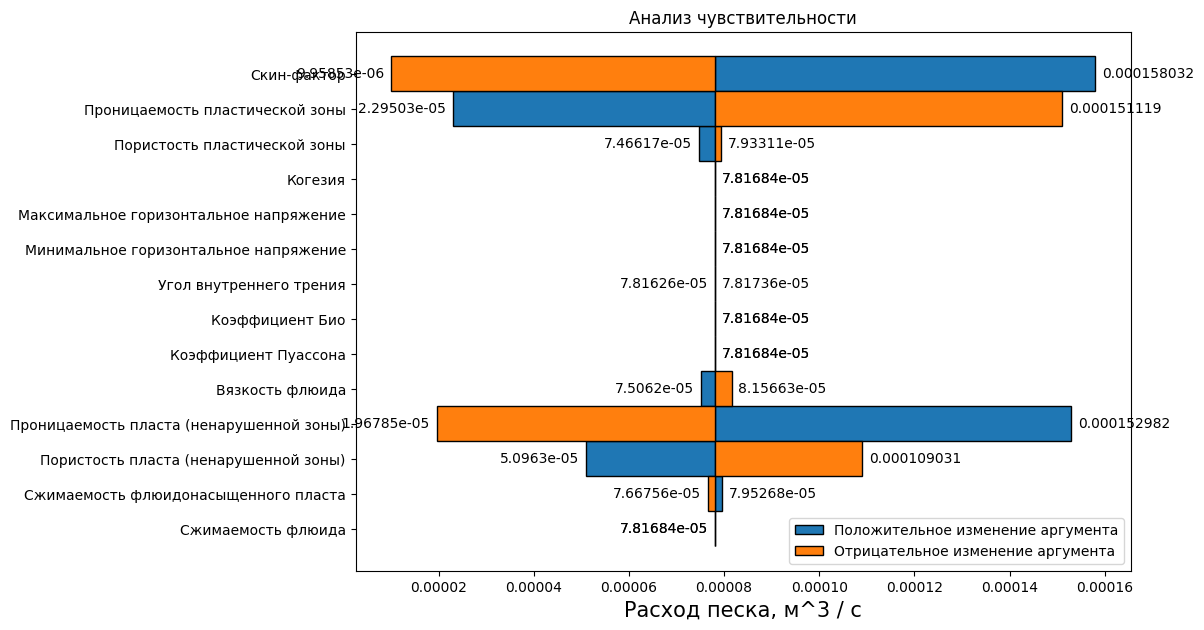

In [13]:
fig, ax = plt.subplots(figsize=(10, 7))

bars = plt.barh(bar_labels_russian, positive_bars, left=Q_s_mean, height=1, linewidth=1, edgecolor='k', label='Положительное изменение аргумента')
ax.bar_label(bars, label_type='edge', padding=5)
bars = plt.barh(bar_labels_russian, negative_bars, left=Q_s_mean, height=1, linewidth=1, edgecolor='k', label='Отрицательное изменение аргумента')
ax.bar_label(bars, label_type='edge', padding=5)
plt.title('', fontsize=15)
plt.xlabel('Расход песка, м^3 / с', fontsize=15)
plt.ylabel('', fontsize=15)
plt.title('Анализ чувствительности')
plt.legend(loc='lower right')
plt.show()